# 从发帖看热点

### 导入必要的第三方包

* `jieba`是流行的python中文分词
* `wordcloud`结合`matplotlib`用来生成关键词的标签云

In [1]:
from model import Posts, Replies

import jieba
import jieba.analyse

from wordcloud import WordCloud
import matplotlib.pyplot as plt

### 载入自定义字典和停止词典

字典里主要是加入一些转债和股票基金的名词，停止词在哈工大的停止词典上加了一些

In [2]:
jieba.load_userdict("dict.txt")
jieba.analyse.set_stop_words("stop_words.txt")

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/dc/bgqcqmcx1g7fhvz7vvyhctbh0000gn/T/jieba.cache
Loading model cost 0.999 seconds.
Prefix dict has been built succesfully.


### 从数据库中取出帖子

这里取出17年12月的所有帖子的标题和内容，看看有多少篇

In [3]:
ps = (Posts.select(Posts.title, Posts.content)
      .where(Posts.updated_at.between('2017-12-01', '2018-01-01')))
len(ps)

3176

### 算出关键词及其权重

将所有内容用空格分开，合成一个大文本，再使用结巴提供的`TF-IDF`算法得出高频词和对应的权重，来看看排名前10的关键词有哪些

In [4]:
full = ' '.join(['%s %s' % (p.title, p.content) for p in ps])

tags = jieba.analyse.extract_tags(full, topK=200, withWeight=True)
tags[:10]

[('转债', 0.04521197535064302),
 ('2017', 0.044203818095825936),
 ('比特币', 0.036758964521792094),
 ('可转债', 0.03550532948979225),
 ('2018', 0.024001897720452855),
 ('投资', 0.021450230509141802),
 ('收益', 0.019623051777057466),
 ('公司', 0.01678389248016652),
 ('美元', 0.015927103030452146),
 ('市场', 0.015786338997360438)]

### 生成标签云

汉字的标签云需要设置字体，稍稍解释一下WordCloud参数的含义

* `scale`：缩放级别，该数值默认为1，越高生成图片质量约好
* `colormap`：可以理解为颜色主题，在[matplotlib colormap](https://matplotlib.org/users/colormaps.html)上选一个即可
* `mode`和`background_color`：当`mode`为*RGBA*，`background_color`设为*None*时，背景为透明

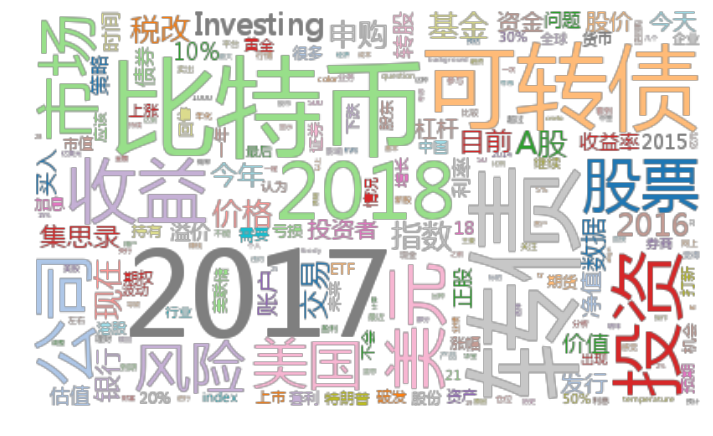

In [5]:
wordcloud = WordCloud(scale=1,
                      width=400, height=240,
                      colormap='tab20',
                      mode='RGBA',
                      background_color=None, 
                      font_path='msyh.ttf').generate_from_frequencies(dict(tags))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

> 去年底`比特币`暴涨到历史最高点又回落，赚足了眼球；`可转债`破发似乎也是史上罕有的事情

### 整合

写成一个函数，输入一个日期和数字，就可以生成该日前后若干个月的词云，方便查看

In [6]:
import arrow

jieba.load_userdict("dict.txt")
jieba.analyse.set_stop_words("stop_words.txt")

def gen_cloud(start, months):
    
    end = arrow.get(start).shift(months=months).format('YYYY-MM-DD')
    if months < 0:
        start, end = end, start
    ps = (Posts.select(Posts.content)
          .where(Posts.updated_at.between(start, end)))

    full = ' '.join([p.content for p in ps])
    tags = jieba.analyse.extract_tags(full, topK=200, withWeight=True)

    wordcloud = WordCloud(scale=1,
                          mode='RGBA',
                          width=400, height=200,
                          colormap='tab20',
                          background_color=None, 
                          font_path='msyh.ttf').generate_from_frequencies(dict(tags))
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


### 来看看15年的大牛市吧

先看看最高点前一个月的(￣ε￣*) 

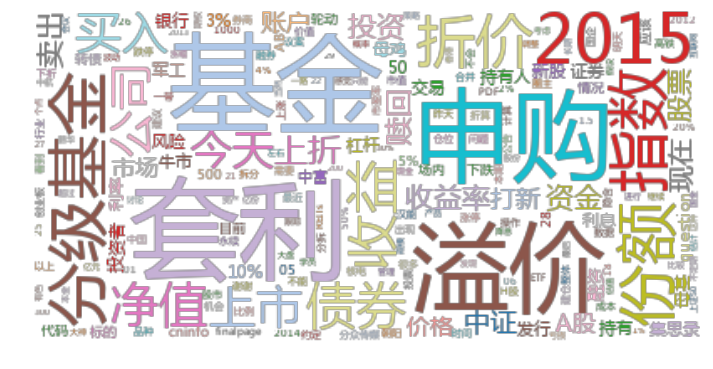

In [7]:
gen_cloud('2015-06-15', -1)

> “套利”，“溢价”，“申购” 是偏向利好的名词

然后就开始跌啦(,,#ﾟДﾟ)

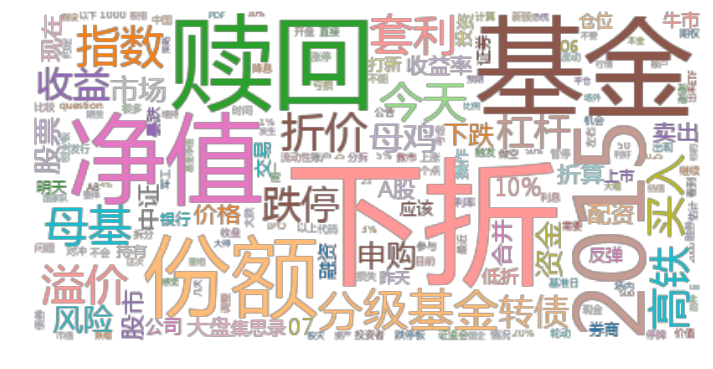

In [8]:
gen_cloud('2015-06-15', 1)

> 一眼就看到了巨大的“下折”和“赎回”